# Ultra fast lowess
Hi, welcome to the Ultra Fast Lowess tutorial

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.api as sm 
lowess = sm.nonparametric.lowess
import dask


In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client.cluster.scale(28)


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46669,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:41979,Total threads: 1
Dashboard: /proxy/35315/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:41267,


In [4]:
# Create sample data
latitudes = np.linspace(-90, 90, 1000)  # Sample latitudes
longitudes = np.linspace(-180, 180, 100)  # Sample longitudes
times = pd.date_range("2024-01-01", periods=500, freq="D")  # 100 time steps

# Create random data for the DataArray
data = np.random.rand(len(times), len(latitudes), len(longitudes))

# Create the xarray DataArray
data_xarray = xr.DataArray(
    data,
    dims=("time", "latitude", "longitude"),
    coords={
        "time": times,
        "latitude": latitudes,
        "longitude": longitudes
    }
)#.chunk({'time':-1, 'latitude':250})

data_xarray.name = 'tas'

In [5]:
data_xarray = data_xarray.chunk({'time':-1,
                                'latitude':25,
                                'longitude': 25})

In [6]:
data_xarray

<xarray.DataArray 'tas' (time: 500, latitude: 1000, longitude: 100)>
dask.array<xarray-<this-array>, shape=(500, 1000, 100), dtype=float64, chunksize=(500, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2025-05-14
  * latitude   (latitude) float64 -90.0 -89.82 -89.64 ... 89.64 89.82 90.0
  * longitude  (longitude) float64 -180.0 -176.4 -172.7 ... 172.7 176.4 180.0

In [8]:
def apply_lowess(arr):
    if all(np.isnan(arr)): return arr

    x = np.arange(arr.shape[0])
    yhat = lowess(arr,x, return_sorted=False)
    return yhat

In [9]:
lowess_ds = xr.apply_ufunc(
    apply_lowess, 
    data_xarray, 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',
    output_dtypes=float
    
)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.682845 to fit


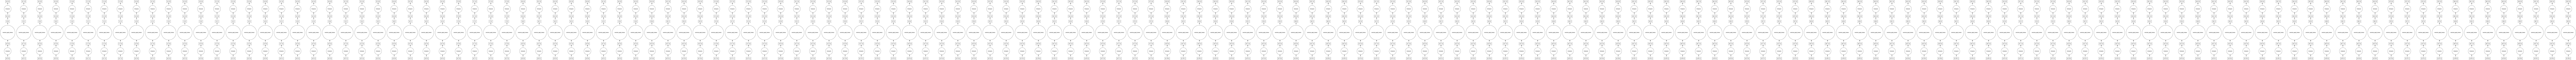

In [10]:
dask.visualize(lowess_ds)

In [11]:
%%time
lowess_ds = lowess_ds.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 381.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 39.5 s, sys: 7.3 s, total: 46.8 s
Wall time: 3min 6s


Matplotlib created a temporary config/cache directory at /jobfs/111353625.gadi-pbs/matplotlib-kichem5l because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


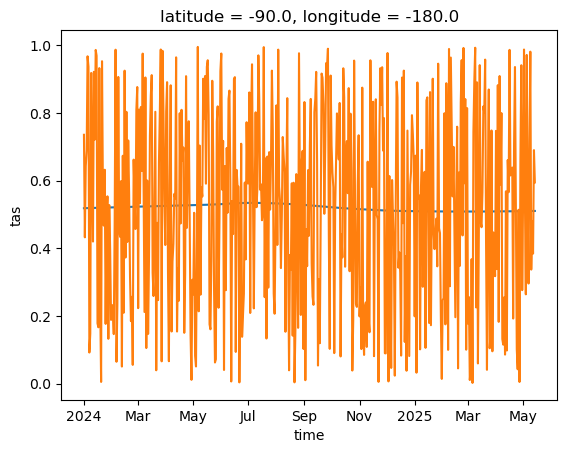

In [12]:
lowess_ds.isel(latitude=0, longitude=0).plot()
data_xarray.isel(latitude=0, longitude=0).plot()